# Assignment - 9: Apply Random Forests & GBDT on Donors Choose dataset

This exercise is to Apply Random Forests & GBDT on Donors Choose dataset and predict approval of a new project proposal.

Relevant Information : The dataset is divided into two files -
1. train.csv file which contains information regarding projects, schools and teachers who submitted the projects. 
2. resources.csv which provides information about the resources required for each project.




### OBJECTIVE : The goal is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school using Random Forests & GBDT.



In [1]:
# Importing the required libraries
# Warning reference : https://stackoverflow.com/questions/41658568/chunkize-warning-while-installing-gensim

%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category = UserWarning , module = 'gensim')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1. Reading the data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

print("\nNumber of data points in train data", project_data.shape)
print('-'*120)
print("The attributes of data :", project_data.columns.values)



Number of data points in train data (109248, 17)
------------------------------------------------------------------------------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [3]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

## NOTE:
1. We have a total of 109248 datapoints and 17 columns.
2. Now we have to sort the data according to date and time so as to have a better prediction on the future data (Test data).
3. As we can see there are null points for project_essay_3 and project_essay_4. Only 3758 points are not null.
4. In teacher_prefix there are 109245 points which means 3 points are null.

### `Sorting according to date`

In [4]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

print(cols)

['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved']


In [5]:
# Dropping the Unnamed column

project_data.drop('Unnamed: 0', axis=1, inplace=True)

### `Adding the price and quantity column from resource_data to the project_data`

In [6]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

# Deleting the resource data variable
del resource_data

## NOTE:
1. As we can see that the price and the quantity column has been added to the project_data
2. This is where the preprocessing will start.
3. we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - essay : text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## 2. Preprocessing Data

### `project_subject_categories`

In [7]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### `project_subject_subcategories`

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## Text Preprocessing

## `Essay`

In [9]:
# Combining all the essay
# merge two column text dataframe: 

project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [10]:
project_data['essay'].describe()

count                                                109248
unique                                               108986
top       At our school, we strive to always be \"Chargi...
freq                                                      5
Name: essay, dtype: object

In [11]:
# Making the decontracted function

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


### STOPWORDS
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


# Combining all the above statements 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:19<00:00, 1376.28it/s]


<h2><font color='red'>project_title</font></h2>

In [12]:
project_data['project_title'].describe()

count               109248
unique              100851
top       Flexible Seating
freq                   234
Name: project_title, dtype: object

In [13]:
# Project_title

# Combining all the above statements 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 31312.33it/s]


### Replacing the columns with new cleaned columns - Project_title and Essay

In [14]:
# Adding processed essay columns in place of previous essays columns and dropping the previous columns

## ESSAY

project_data['clean_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
project_data.drop(['essay'], axis=1, inplace=True)

In [15]:
## Project_title

# Adding processed project_title columns in place of previous project_title column and dropping the previous column

project_data['clean_titles'] = preprocessed_titles

project_data.drop(['project_title'], axis=1, inplace=True)


### Dropping the nan rows present in teacher_prefix

In [16]:
# Dropping NAN row
# https://stackoverflow.com/questions/46091924/python-how-to-drop-a-row-whose-particular-column-is-empty-nan

project_data.dropna(axis = 0, inplace = True, subset = ['teacher_prefix'])

In [17]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109245 entries, 0 to 109247
Data columns (total 15 columns):
id                                              109245 non-null object
teacher_id                                      109245 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109245 non-null object
Date                                            109245 non-null datetime64[ns]
project_grade_category                          109245 non-null object
project_resource_summary                        109245 non-null object
teacher_number_of_previously_posted_projects    109245 non-null int64
project_is_approved                             109245 non-null int64
price                                           109245 non-null float64
quantity                                        109245 non-null int64
clean_categories                                109245 non-null object
clean_subcategories            

## NOTE:
    - Till now we have preprocessed the data. 
    - Now we have to split the data and vectorize the data for BOW, TF-IDF, Avg W2V and TFIDF weighted W2Vec

<h1><font color='red'>************************************ASSIGNMENT************************************</font></h1>

<h2>3. Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [18]:
# Creating label and feature data frame : Label- y, Features- X

y = project_data['project_is_approved'].values
X = project_data

print(y.shape)
print(X.shape)

(109245,)
(109245, 15)


In [19]:
## train test cross-validation split
# Referance : https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## NOTE:
    - This `stratify` parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

    - For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [20]:
## Shape of the matrices

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49039, 15) (49039,)
(24155, 15) (24155,)
(36051, 15) (36051,)


## NOTE:
1. We will now use the train data for training our model, cv data to validate the model and perform testing on the test data

<h1>4. Make Data Model Ready: encoding numerical, categorical features</h1>

## `Response coding for Categorical Data`

## NOTE:
    - The categorical data we have are:
        - clean_categories
        - clean_subcategories
        - teacher_prefix
        - school_state
        - project_grade_category

In [21]:
X_train.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date',
       'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_essays', 'clean_titles'],
      dtype='object')

### Creating the response table on the train dataset and then apply it on cv and test data

#### For a category which is not there in train data and present in test data, we will encode them with default values Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

In [22]:
# Finding the positive and negative classes for the categories

X_train_pos = X_train.loc[X_train['project_is_approved'] == 1]
X_train_neg = X_train.loc[X_train['project_is_approved'] == 0]

print("Approved Projects (in train) : ", X_train_pos.shape)
print("Not Approved Projects (in train) :", X_train_neg.shape)

Approved Projects (in train) :  (41614, 15)
Not Approved Projects (in train) : (7425, 15)


### `1. clean_categories`

In [23]:
## Finding the positive class count for each category

pos_clean_category = {}

for categ in X_train_pos['clean_categories'] :
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in pos_clean_category :
            pos_clean_category[cat] = 1
            
        else :
            pos_clean_category[cat] += 1

print("Categories in pos_clean_categories : ", len(pos_clean_category))
pos_clean_category

Categories in pos_clean_categories :  9


{'Health_Sports': 5470,
 'Literacy_Language': 20338,
 'Math_Science': 15666,
 'SpecialNeeds': 5184,
 'AppliedLearning': 4462,
 'Music_Arts': 3886,
 'History_Civics': 2230,
 'Warmth': 563,
 'Care_Hunger': 563}

In [24]:
## Finding the negative class count for each category

neg_clean_categories = {}

for categ in X_train_neg['clean_categories']:
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in neg_clean_categories:
            neg_clean_categories[cat] = 1
            
        else :
            neg_clean_categories[cat] += 1

print("Categories in neg_clean_categories : ", len(neg_clean_categories))
neg_clean_categories

Categories in neg_clean_categories :  9


{'Math_Science': 2948,
 'AppliedLearning': 936,
 'SpecialNeeds': 1021,
 'History_Civics': 378,
 'Literacy_Language': 3132,
 'Health_Sports': 1017,
 'Music_Arts': 695,
 'Warmth': 53,
 'Care_Hunger': 53}

In [25]:
## Finding the total class count for each category

total_clean_categories = {}

for categ in X_train['clean_categories']:
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in total_clean_categories:
            total_clean_categories[cat] = 1
            
        else :
            total_clean_categories[cat] += 1

print("Categories in total_clean_categories : ", len(total_clean_categories))
total_clean_categories

Categories in total_clean_categories :  9


{'Health_Sports': 6487,
 'Math_Science': 18614,
 'Literacy_Language': 23470,
 'SpecialNeeds': 6205,
 'AppliedLearning': 5398,
 'Music_Arts': 4581,
 'History_Civics': 2608,
 'Warmth': 616,
 'Care_Hunger': 616}

### Now we have the total positive count, total negative count and total count of each class and category

## Finding the probabilities for each class

In [26]:
# Finding positive class probability

pos_prob_clean_category = {}

for k in total_clean_categories.keys():
    pos_prob_clean_category[k] = (pos_clean_category[k])/float(total_clean_categories[k])

print("Probability of getting the positive class value : ")
pos_prob_clean_category

Probability of getting the positive class value : 


{'Health_Sports': 0.8432249113611839,
 'Math_Science': 0.8416245836467176,
 'Literacy_Language': 0.8665530464422667,
 'SpecialNeeds': 0.8354552780016116,
 'AppliedLearning': 0.8266024453501297,
 'Music_Arts': 0.8482864003492687,
 'History_Civics': 0.8550613496932515,
 'Warmth': 0.913961038961039,
 'Care_Hunger': 0.913961038961039}

In [27]:
# Finding negative class probability

neg_prob_clean_category = {}

for key in total_clean_categories.keys():
    neg_prob_clean_category[key] = (neg_clean_categories[key])/float(total_clean_categories[key])

print("Probability of getting the negative class value : ")
neg_prob_clean_category

Probability of getting the negative class value : 


{'Health_Sports': 0.1567750886388161,
 'Math_Science': 0.15837541635328248,
 'Literacy_Language': 0.13344695355773328,
 'SpecialNeeds': 0.1645447219983884,
 'AppliedLearning': 0.17339755464987033,
 'Music_Arts': 0.15171359965073128,
 'History_Civics': 0.14493865030674846,
 'Warmth': 0.08603896103896104,
 'Care_Hunger': 0.08603896103896104}

## Applying the probabilities to Train, CV, Test sets

## Train

In [28]:
clean_cat_train_0 = []
clean_cat_train_1 = []

for k in X_train["clean_categories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_cat_train_0.append(neg_prob_clean_category[k])
        clean_cat_train_1.append(pos_prob_clean_category[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_category[cat[0]]
        d = neg_prob_clean_category[cat[1]]
        e = pos_prob_clean_category[cat[0]]
        f = pos_prob_clean_category[cat[1]]
        
        clean_cat_train_0.append(c*d)
        clean_cat_train_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_category[cat[1]]
        j = neg_prob_clean_category[cat[2]]
        k = pos_prob_clean_category[cat[1]]
        l = pos_prob_clean_category[cat[2]]
        
        clean_cat_train_0.append(i*j)
        clean_cat_train_1.append(k*l)

### Creating the new columns in X_train

In [29]:
X_train["clean_categories_0"] = clean_cat_train_0
X_train["clean_categories_1"] = clean_cat_train_1

In [30]:
X_train.shape

(49039, 17)

## CV

In [31]:
clean_cat_cv_0 = []
clean_cat_cv_1 = []

for k in X_cv["clean_categories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_cat_cv_0.append(neg_prob_clean_category[k])
        clean_cat_cv_1.append(pos_prob_clean_category[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_category[cat[0]]
        d = neg_prob_clean_category[cat[1]]
        e = pos_prob_clean_category[cat[0]]
        f = pos_prob_clean_category[cat[1]]
        
        clean_cat_cv_0.append(c*d)
        clean_cat_cv_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_category[cat[1]]
        j = neg_prob_clean_category[cat[2]]
        k = pos_prob_clean_category[cat[1]]
        l = pos_prob_clean_category[cat[2]]
        
        clean_cat_cv_0.append(i*j)
        clean_cat_cv_1.append(k*l)

### Creating new columns in X_cv

In [32]:
X_cv["clean_categories_0"] = clean_cat_cv_0
X_cv["clean_categories_1"] = clean_cat_cv_1

In [33]:
X_cv.shape

(24155, 17)

## Test

In [34]:
clean_cat_test_0 = []
clean_cat_test_1 = []

for k in X_test["clean_categories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_cat_test_0.append(neg_prob_clean_category[k])
        clean_cat_test_1.append(pos_prob_clean_category[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_category[cat[0]]
        d = neg_prob_clean_category[cat[1]]
        e = pos_prob_clean_category[cat[0]]
        f = pos_prob_clean_category[cat[1]]
        
        clean_cat_test_0.append(c*d)
        clean_cat_test_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_category[cat[1]]
        j = neg_prob_clean_category[cat[2]]
        k = pos_prob_clean_category[cat[1]]
        l = pos_prob_clean_category[cat[2]]
        
        clean_cat_test_0.append(i*j)
        clean_cat_test_1.append(k*l)

### Creating new column in X_test

In [35]:
X_test = X_test.copy()
X_test["clean_categories_0"] = clean_cat_test_0
X_test["clean_categories_1"] = clean_cat_test_1

In [36]:
X_test.shape

(36051, 17)

### `2. clean_subcategories`

In [37]:
## Finding the positive class count for each subcategory

pos_clean_subcategory = {}

for categ in X_train_pos['clean_subcategories']:
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in pos_clean_subcategory:
            pos_clean_subcategory[cat] = 1
            
        else :
            pos_clean_subcategory[cat] += 1

print("Categories in pos_clean_subcategories : ", len(pos_clean_subcategory))
pos_clean_subcategory

Categories in pos_clean_subcategories :  30


{'Gym_Fitness': 1691,
 'Health_Wellness': 4038,
 'Literature_Writing': 8491,
 'Mathematics': 10687,
 'SpecialNeeds': 5184,
 'Health_LifeScience': 1553,
 'ESL': 1678,
 'Literacy': 13295,
 'EarlyDevelopment': 1528,
 'EnvironmentalScience': 2097,
 'AppliedSciences': 4022,
 'VisualArts': 2314,
 'College_CareerPrep': 963,
 'Music': 1233,
 'Extracurricular': 294,
 'Economics': 90,
 'FinancialLiteracy': 201,
 'PerformingArts': 769,
 'ForeignLanguages': 329,
 'Warmth': 563,
 'Care_Hunger': 563,
 'TeamSports': 772,
 'NutritionEducation': 514,
 'Other': 892,
 'History_Geography': 1205,
 'SocialSciences': 726,
 'CharacterEducation': 736,
 'ParentInvolvement': 267,
 'Civics_Government': 316,
 'CommunityService': 137}

In [38]:
## Finding the negative class count for each subcategory

neg_clean_subcategories = {}

for categ in X_train_neg['clean_subcategories']:
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in neg_clean_subcategories:
            neg_clean_subcategories[cat] = 1
            
        else :
            neg_clean_subcategories[cat] += 1

print("Categories in neg_clean_subcategories : ", len(neg_clean_subcategories))
neg_clean_subcategories

Categories in neg_clean_subcategories :  30


{'AppliedSciences': 835,
 'Mathematics': 1953,
 'EarlyDevelopment': 326,
 'SpecialNeeds': 1021,
 'History_Geography': 200,
 'Literature_Writing': 1417,
 'Literacy': 1908,
 'EnvironmentalScience': 451,
 'Health_LifeScience': 317,
 'Gym_Fitness': 328,
 'Health_Wellness': 661,
 'TeamSports': 216,
 'VisualArts': 466,
 'Other': 168,
 'ESL': 307,
 'College_CareerPrep': 205,
 'ForeignLanguages': 55,
 'NutritionEducation': 116,
 'Music': 174,
 'CharacterEducation': 183,
 'Extracurricular': 57,
 'SocialSciences': 124,
 'FinancialLiteracy': 38,
 'CommunityService': 51,
 'Warmth': 53,
 'Care_Hunger': 53,
 'Economics': 23,
 'PerformingArts': 123,
 'ParentInvolvement': 40,
 'Civics_Government': 54}

In [39]:
## Finding the total class count for each subcategory

total_clean_subcategories = {}

for categ in X_train['clean_subcategories']:
    
    # Splitting multiple categories
    for cat in categ.split():
        
        if cat not in total_clean_subcategories:
            total_clean_subcategories[cat] = 1
            
        else :
            total_clean_subcategories[cat] += 1

print("Categories in total_clean_categories : ", len(total_clean_subcategories))
total_clean_subcategories

Categories in total_clean_categories :  30


{'Gym_Fitness': 2019,
 'Health_Wellness': 4699,
 'AppliedSciences': 4857,
 'Mathematics': 12640,
 'Literature_Writing': 9908,
 'SpecialNeeds': 6205,
 'Health_LifeScience': 1870,
 'ESL': 1985,
 'Literacy': 15203,
 'EarlyDevelopment': 1854,
 'EnvironmentalScience': 2548,
 'VisualArts': 2780,
 'College_CareerPrep': 1168,
 'History_Geography': 1405,
 'Music': 1407,
 'Extracurricular': 351,
 'Economics': 113,
 'FinancialLiteracy': 239,
 'PerformingArts': 892,
 'ForeignLanguages': 384,
 'Warmth': 616,
 'Care_Hunger': 616,
 'TeamSports': 988,
 'NutritionEducation': 630,
 'Other': 1060,
 'SocialSciences': 850,
 'CharacterEducation': 919,
 'ParentInvolvement': 307,
 'Civics_Government': 370,
 'CommunityService': 188}

### Now we have the total positive count, total negative count and total count of each class and category

## Finding the probabilities for each class

In [40]:
# Finding positive class probability

pos_prob_clean_subcategory = {}

for k in total_clean_subcategories.keys():
    pos_prob_clean_subcategory[k] = (pos_clean_subcategory[k])/float(total_clean_subcategories[k])

print("Probability of getting the positive class value : ")
pos_prob_clean_subcategory

Probability of getting the positive class value : 


{'Gym_Fitness': 0.8375433382862804,
 'Health_Wellness': 0.8593317727175995,
 'AppliedSciences': 0.828083178917027,
 'Mathematics': 0.8454905063291139,
 'Literature_Writing': 0.8569842551473557,
 'SpecialNeeds': 0.8354552780016116,
 'Health_LifeScience': 0.8304812834224599,
 'ESL': 0.8453400503778338,
 'Literacy': 0.8744984542524502,
 'EarlyDevelopment': 0.8241639697950378,
 'EnvironmentalScience': 0.8229984301412873,
 'VisualArts': 0.8323741007194244,
 'College_CareerPrep': 0.824486301369863,
 'History_Geography': 0.8576512455516014,
 'Music': 0.8763326226012793,
 'Extracurricular': 0.8376068376068376,
 'Economics': 0.7964601769911505,
 'FinancialLiteracy': 0.8410041841004184,
 'PerformingArts': 0.8621076233183856,
 'ForeignLanguages': 0.8567708333333334,
 'Warmth': 0.913961038961039,
 'Care_Hunger': 0.913961038961039,
 'TeamSports': 0.7813765182186235,
 'NutritionEducation': 0.8158730158730159,
 'Other': 0.8415094339622642,
 'SocialSciences': 0.8541176470588235,
 'CharacterEducation':

In [41]:
# Finding negative class probability

neg_prob_clean_subcategory = {}

for key in total_clean_subcategories.keys():
    neg_prob_clean_subcategory[key] = (neg_clean_subcategories[key])/float(total_clean_subcategories[key])

print("Probability of getting the negative class value : ")
neg_prob_clean_subcategory

Probability of getting the negative class value : 


{'Gym_Fitness': 0.16245666171371967,
 'Health_Wellness': 0.1406682272824005,
 'AppliedSciences': 0.17191682108297301,
 'Mathematics': 0.15450949367088607,
 'Literature_Writing': 0.14301574485264432,
 'SpecialNeeds': 0.1645447219983884,
 'Health_LifeScience': 0.1695187165775401,
 'ESL': 0.15465994962216625,
 'Literacy': 0.12550154574754982,
 'EarlyDevelopment': 0.17583603020496225,
 'EnvironmentalScience': 0.1770015698587127,
 'VisualArts': 0.16762589928057553,
 'College_CareerPrep': 0.175513698630137,
 'History_Geography': 0.1423487544483986,
 'Music': 0.12366737739872068,
 'Extracurricular': 0.1623931623931624,
 'Economics': 0.20353982300884957,
 'FinancialLiteracy': 0.1589958158995816,
 'PerformingArts': 0.13789237668161436,
 'ForeignLanguages': 0.14322916666666666,
 'Warmth': 0.08603896103896104,
 'Care_Hunger': 0.08603896103896104,
 'TeamSports': 0.21862348178137653,
 'NutritionEducation': 0.18412698412698414,
 'Other': 0.15849056603773584,
 'SocialSciences': 0.14588235294117646,
 

## Applying the probabilities to Train, CV, Test sets

## Train

In [42]:
clean_subcat_train_0 = []
clean_subcat_train_1 = []

for k in X_train["clean_subcategories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_subcat_train_0.append(neg_prob_clean_subcategory[k])
        clean_subcat_train_1.append(pos_prob_clean_subcategory[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_subcategory[cat[0]]
        d = neg_prob_clean_subcategory[cat[1]]
        e = pos_prob_clean_subcategory[cat[0]]
        f = pos_prob_clean_subcategory[cat[1]]
        
        clean_subcat_train_0.append(c*d)
        clean_subcat_train_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_subcategory[cat[1]]
        j = neg_prob_clean_subcategory[cat[2]]
        k = pos_prob_clean_subcategory[cat[1]]
        l = pos_prob_clean_subcategory[cat[2]]
        
        clean_subcat_train_0.append(i*j)
        clean_subcat_train_1.append(k*l)

### Creating new column in X_train

In [43]:
X_train["clean_subcategories_0"] = clean_subcat_train_0
X_train["clean_subcategories_1"] = clean_subcat_train_1

In [44]:
X_train.shape

(49039, 19)

## CV

In [45]:
clean_subcat_cv_0 = []
clean_subcat_cv_1 = []

for k in X_cv["clean_subcategories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_subcat_cv_0.append(neg_prob_clean_subcategory[k])
        clean_subcat_cv_1.append(pos_prob_clean_subcategory[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_subcategory[cat[0]]
        d = neg_prob_clean_subcategory[cat[1]]
        e = pos_prob_clean_subcategory[cat[0]]
        f = pos_prob_clean_subcategory[cat[1]]
        
        clean_subcat_cv_0.append(c*d)
        clean_subcat_cv_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_subcategory[cat[1]]
        j = neg_prob_clean_subcategory[cat[2]]
        k = pos_prob_clean_subcategory[cat[1]]
        l = pos_prob_clean_subcategory[cat[2]]
        
        clean_subcat_cv_0.append(i*j)
        clean_subcat_cv_1.append(k*l)

### Creating new column in X_cv

In [46]:
X_cv["clean_subcategories_0"] = clean_subcat_cv_0
X_cv["clean_subcategories_1"] = clean_subcat_cv_1

In [47]:
X_cv.shape

(24155, 19)

## Test

In [48]:
clean_subcat_test_0 = []
clean_subcat_test_1 = []

for k in X_test["clean_subcategories"]:
    
    # Splitting multiple categories
    cat = k.split()
    
    # If it has only 1 category
    if len(cat) == 1 :
        clean_subcat_test_0.append(neg_prob_clean_subcategory[k])
        clean_subcat_test_1.append(pos_prob_clean_subcategory[k])
    
    # If there are 2 categories
    elif len(cat) == 2:
        c = neg_prob_clean_subcategory[cat[0]]
        d = neg_prob_clean_subcategory[cat[1]]
        e = pos_prob_clean_subcategory[cat[0]]
        f = pos_prob_clean_subcategory[cat[1]]
        
        clean_subcat_test_0.append(c*d)
        clean_subcat_test_1.append(e*f)
        
    # If there are 3 categories
    else:
        i = neg_prob_clean_subcategory[cat[1]]
        j = neg_prob_clean_subcategory[cat[2]]
        k = pos_prob_clean_subcategory[cat[1]]
        l = pos_prob_clean_subcategory[cat[2]]
        
        clean_subcat_test_0.append(i*j)
        clean_subcat_test_1.append(k*l)

### Creating new column in X_test

In [49]:
X_test = X_test.copy()
X_test["clean_subcategories_0"] = clean_subcat_test_0
X_test["clean_subcategories_1"] = clean_subcat_test_0

In [50]:
X_test.shape

(36051, 19)

### `3. teacher_prefix`

In [51]:
## Finding the positive class count for each teacher_prefix

pos_teacher_prefix = {}

for cat in X_train_pos['teacher_prefix']:

    if cat not in pos_teacher_prefix:
        pos_teacher_prefix[cat] = 1

    else :
        pos_teacher_prefix[cat] += 1

print("Categories in pos_teacher_prefix : ", len(pos_teacher_prefix))
pos_teacher_prefix

Categories in pos_teacher_prefix :  5


{'Teacher': 842, 'Mrs.': 21951, 'Ms.': 14757, 'Mr.': 4060, 'Dr.': 4}

In [52]:
## Finding the negative class count for each teacher_prefix

neg_teacher_prefix = {}

for cat in X_train_neg['teacher_prefix']:

    if cat not in neg_teacher_prefix:
        neg_teacher_prefix[cat] = 1

    else :
        neg_teacher_prefix[cat] += 1

print("Categories in neg_teacher_prefix : ", len(neg_teacher_prefix))
neg_teacher_prefix

Categories in neg_teacher_prefix :  5


{'Mrs.': 3688, 'Ms.': 2757, 'Teacher': 208, 'Mr.': 769, 'Dr.': 3}

In [53]:
## Finding the total class count for each teacher_prefix

total_teacher_prefix = {}

for cat in X_train['teacher_prefix']:

    if cat not in total_teacher_prefix:
        total_teacher_prefix[cat] = 1

    else :
        total_teacher_prefix[cat] += 1

print("Categories in total_teacher_prefix : ", len(total_teacher_prefix))
total_teacher_prefix

Categories in total_teacher_prefix :  5


{'Teacher': 1050, 'Mrs.': 25639, 'Ms.': 17514, 'Mr.': 4829, 'Dr.': 7}

### Now we have the total positive count, total negative count and total count of each class and category

## Finding the probabilities for each class

In [54]:
# Finding positive class probability

pos_prob_teacher_prefix = {}

for k in total_teacher_prefix.keys():
    pos_prob_teacher_prefix[k] = (pos_teacher_prefix[k])/float(total_teacher_prefix[k])

print("Probability of getting the positive class value : ")
pos_prob_teacher_prefix

Probability of getting the positive class value : 


{'Teacher': 0.8019047619047619,
 'Mrs.': 0.8561566363742735,
 'Ms.': 0.842583076396026,
 'Mr.': 0.8407537792503624,
 'Dr.': 0.5714285714285714}

In [55]:
# Finding negative class probability

neg_prob_teacher_prefix = {}

for k in total_teacher_prefix.keys():
    neg_prob_teacher_prefix[k] = (neg_teacher_prefix[k])/float(total_teacher_prefix[k])

print("Probability of getting the negative class value : ")
neg_prob_teacher_prefix

Probability of getting the negative class value : 


{'Teacher': 0.1980952380952381,
 'Mrs.': 0.14384336362572644,
 'Ms.': 0.15741692360397397,
 'Mr.': 0.1592462207496376,
 'Dr.': 0.42857142857142855}

## Applying the probabilities to Train, CV, Test sets

## Train

In [56]:
teacher_pref_train_0 = []
teacher_pref_train_1 = []

for k in X_train["teacher_prefix"]:

    teacher_pref_train_0.append(neg_prob_teacher_prefix[k])
    teacher_pref_train_1.append(pos_prob_teacher_prefix[k])

### Creating a new column in X_train

In [57]:
X_train["teacher_prefix_0"] = teacher_pref_train_0
X_train["teacher_prefix_1"] = teacher_pref_train_1

In [58]:
X_train.shape

(49039, 21)

## CV

In [59]:
teacher_pref_cv_0 = []
teacher_pref_cv_1 = []

for k in X_cv["teacher_prefix"]:

    teacher_pref_cv_0.append(neg_prob_teacher_prefix[k])
    teacher_pref_cv_1.append(pos_prob_teacher_prefix[k])

### Creating a new column in X_cv

In [60]:
X_cv["teacher_prefix_0"] = teacher_pref_cv_0
X_cv["teacher_prefix_1"] = teacher_pref_cv_1

In [61]:
X_cv.shape

(24155, 21)

## Test

In [62]:
teacher_pref_test_0 = []
teacher_pref_test_1 = []

for k in X_test["teacher_prefix"]:

    teacher_pref_test_0.append(neg_prob_teacher_prefix[k])
    teacher_pref_test_1.append(pos_prob_teacher_prefix[k])

### Creating a new column in X_test

In [63]:
X_test = X_test.copy()
X_test["teacher_prefix_0"] = teacher_pref_test_0
X_test["teacher_prefix_1"] = teacher_pref_test_1

In [64]:
X_test.shape

(36051, 21)

### `4. school_state`

In [65]:
## Finding the positive class count for each school_state

pos_school_state = {}

for cat in X_train_pos['school_state']:

    if cat not in pos_school_state:
        pos_school_state[cat] = 1

    else :
        pos_school_state[cat] += 1

print("Categories in pos_school_state : ", len(pos_school_state))
pos_school_state

Categories in pos_school_state :  51


{'CA': 5983,
 'OH': 1015,
 'WA': 917,
 'NY': 2800,
 'NE': 107,
 'MO': 972,
 'NC': 1969,
 'FL': 2314,
 'VA': 827,
 'IA': 242,
 'WV': 200,
 'DC': 212,
 'SC': 1499,
 'UT': 641,
 'PA': 1197,
 'IN': 1015,
 'GA': 1495,
 'AR': 387,
 'AL': 668,
 'NJ': 862,
 'IL': 1671,
 'TX': 2648,
 'OR': 456,
 'KY': 487,
 'MA': 905,
 'MS': 483,
 'MI': 1198,
 'HI': 194,
 'OK': 831,
 'LA': 880,
 'NH': 139,
 'WI': 697,
 'CT': 648,
 'AZ': 845,
 'CO': 410,
 'TN': 653,
 'KS': 228,
 'MN': 460,
 'NV': 510,
 'AK': 144,
 'MT': 85,
 'ND': 60,
 'RI': 118,
 'MD': 567,
 'NM': 218,
 'SD': 112,
 'DE': 133,
 'ME': 199,
 'ID': 251,
 'VT': 30,
 'WY': 32}

In [66]:
## Finding the negative class count for each school_state

neg_school_state = {}

for cat in X_train_neg['school_state']:

    if cat not in neg_school_state:
        neg_school_state[cat] = 1

    else :
        neg_school_state[cat] += 1

print("Categories in neg_school_state : ", len(neg_school_state))
neg_school_state

Categories in neg_school_state :  51


{'IN': 170,
 'NM': 41,
 'IL': 288,
 'CA': 964,
 'SC': 249,
 'CT': 96,
 'PA': 210,
 'LA': 173,
 'VA': 140,
 'KY': 76,
 'TX': 645,
 'AZ': 161,
 'FL': 465,
 'NJ': 160,
 'NY': 461,
 'NH': 24,
 'NC': 305,
 'WA': 138,
 'AL': 130,
 'MN': 72,
 'GA': 295,
 'WI': 130,
 'MS': 90,
 'MI': 232,
 'UT': 122,
 'OH': 131,
 'IA': 41,
 'CO': 80,
 'HI': 43,
 'MO': 171,
 'MA': 156,
 'AR': 85,
 'OR': 90,
 'NV': 95,
 'MD': 91,
 'KS': 47,
 'DC': 50,
 'TN': 112,
 'OK': 149,
 'DE': 11,
 'ID': 45,
 'ME': 38,
 'NE': 19,
 'RI': 20,
 'WV': 30,
 'MT': 21,
 'AK': 23,
 'SD': 18,
 'VT': 9,
 'WY': 6,
 'ND': 7}

In [67]:
## Finding the total class count for each school_state

total_school_state = {}

for cat in X_train['school_state']:

    if cat not in total_school_state:
        total_school_state[cat] = 1

    else :
        total_school_state[cat] += 1

print("Categories in total_school_state : ", len(total_school_state))
total_school_state

Categories in total_school_state :  51


{'CA': 6947,
 'IN': 1185,
 'OH': 1146,
 'WA': 1055,
 'NY': 3261,
 'NE': 126,
 'MO': 1143,
 'NC': 2274,
 'FL': 2779,
 'VA': 967,
 'IA': 283,
 'NM': 259,
 'WV': 230,
 'DC': 262,
 'SC': 1748,
 'IL': 1959,
 'UT': 763,
 'PA': 1407,
 'GA': 1790,
 'AR': 472,
 'AL': 798,
 'NJ': 1022,
 'TX': 3293,
 'OR': 546,
 'CT': 744,
 'KY': 563,
 'MA': 1061,
 'MS': 573,
 'MI': 1430,
 'LA': 1053,
 'HI': 237,
 'OK': 980,
 'NH': 163,
 'WI': 827,
 'AZ': 1006,
 'CO': 490,
 'TN': 765,
 'KS': 275,
 'MN': 532,
 'NV': 605,
 'AK': 167,
 'MT': 106,
 'ND': 67,
 'RI': 138,
 'MD': 658,
 'SD': 130,
 'DE': 144,
 'ME': 237,
 'ID': 296,
 'VT': 39,
 'WY': 38}

### Now we have the total positive count, total negative count and total count of each class and category

## Finding the probabilities for each class

In [68]:
# Finding positive class probability

pos_prob_school_state = {}

for k in total_school_state.keys():
    pos_prob_school_state[k] = (pos_school_state[k])/float(total_school_state[k])

print("Probability of getting the positive class value : ")
pos_prob_school_state

Probability of getting the positive class value : 


{'CA': 0.8612350654958975,
 'IN': 0.8565400843881856,
 'OH': 0.8856893542757417,
 'WA': 0.8691943127962085,
 'NY': 0.8586323213738117,
 'NE': 0.8492063492063492,
 'MO': 0.8503937007874016,
 'NC': 0.8658751099384345,
 'FL': 0.8326736236056135,
 'VA': 0.8552223371251293,
 'IA': 0.8551236749116607,
 'NM': 0.8416988416988417,
 'WV': 0.8695652173913043,
 'DC': 0.8091603053435115,
 'SC': 0.8575514874141876,
 'IL': 0.8529862174578867,
 'UT': 0.8401048492791612,
 'PA': 0.8507462686567164,
 'GA': 0.835195530726257,
 'AR': 0.8199152542372882,
 'AL': 0.8370927318295739,
 'NJ': 0.8434442270058709,
 'TX': 0.8041299726692985,
 'OR': 0.8351648351648352,
 'CT': 0.8709677419354839,
 'KY': 0.8650088809946714,
 'MA': 0.8529688972667295,
 'MS': 0.8429319371727748,
 'MI': 0.8377622377622378,
 'LA': 0.835707502374169,
 'HI': 0.8185654008438819,
 'OK': 0.8479591836734693,
 'NH': 0.852760736196319,
 'WI': 0.8428053204353083,
 'AZ': 0.8399602385685885,
 'CO': 0.8367346938775511,
 'TN': 0.85359477124183,
 'KS':

In [69]:
# Finding negative class probability

neg_prob_school_state = {}

for k in total_school_state.keys():
    neg_prob_school_state[k] = (neg_school_state[k])/float(total_school_state[k])

print("Probability of getting the negative class value : ")
neg_prob_school_state

Probability of getting the negative class value : 


{'CA': 0.1387649345041025,
 'IN': 0.14345991561181434,
 'OH': 0.1143106457242583,
 'WA': 0.13080568720379146,
 'NY': 0.1413676786261883,
 'NE': 0.15079365079365079,
 'MO': 0.14960629921259844,
 'NC': 0.13412489006156553,
 'FL': 0.16732637639438647,
 'VA': 0.14477766287487073,
 'IA': 0.14487632508833923,
 'NM': 0.1583011583011583,
 'WV': 0.13043478260869565,
 'DC': 0.19083969465648856,
 'SC': 0.14244851258581237,
 'IL': 0.14701378254211334,
 'UT': 0.1598951507208388,
 'PA': 0.14925373134328357,
 'GA': 0.164804469273743,
 'AR': 0.18008474576271186,
 'AL': 0.16290726817042606,
 'NJ': 0.15655577299412915,
 'TX': 0.1958700273307015,
 'OR': 0.16483516483516483,
 'CT': 0.12903225806451613,
 'KY': 0.1349911190053286,
 'MA': 0.1470311027332705,
 'MS': 0.15706806282722513,
 'MI': 0.16223776223776223,
 'LA': 0.16429249762583095,
 'HI': 0.18143459915611815,
 'OK': 0.1520408163265306,
 'NH': 0.147239263803681,
 'WI': 0.15719467956469166,
 'AZ': 0.16003976143141152,
 'CO': 0.16326530612244897,
 'TN'

## Applying the probabilities to Train, CV, Test sets

## Train

In [70]:
school_state_train_0 = []
school_state_train_1 = []

for k in X_train["school_state"]:

    school_state_train_0.append(neg_prob_school_state[k])
    school_state_train_1.append(pos_prob_school_state[k])

### Creating a new column in X_train

In [71]:
X_train["school_state_0"] = school_state_train_0
X_train["school_state_1"] = school_state_train_1

In [72]:
X_train.shape

(49039, 23)

## CV

In [73]:
school_state_cv_0 = []
school_state_cv_1 = []

for k in X_cv["school_state"]:

    school_state_cv_0.append(neg_prob_school_state[k])
    school_state_cv_1.append(pos_prob_school_state[k])

### Creating a new column in X_cv

In [74]:
X_cv["school_state_0"] = school_state_cv_0
X_cv["school_state_1"] = school_state_cv_1

In [75]:
X_cv.shape

(24155, 23)

## Test

In [76]:
school_state_test_0 = []
school_state_test_1 = []

for k in X_test["school_state"]:

    school_state_test_0.append(neg_prob_school_state[k])
    school_state_test_1.append(pos_prob_school_state[k])

### Creating a new column in X_test

In [77]:
X_test = X_test.copy()
X_test["school_state_0"] = school_state_test_0
X_test["school_state_1"] = school_state_test_0

In [78]:
X_test.shape

(36051, 23)

### `5. project_grade_category`

In [79]:
## Finding the positive class count for each proj_grade

pos_proj_grade = {}

for cat in X_train_pos['project_grade_category']:

    if cat not in pos_proj_grade:
        pos_proj_grade[cat] = 1

    else :
        pos_proj_grade[cat] += 1

print("Categories in pos_proj_grade : ", len(pos_proj_grade))
pos_proj_grade

Categories in pos_proj_grade :  4


{'Grades 3-5': 14179,
 'Grades PreK-2': 16929,
 'Grades 6-8': 6423,
 'Grades 9-12': 4083}

In [80]:
## Finding the negative class count for each proj_grade

neg_proj_grade = {}

for cat in X_train_neg['project_grade_category']:

    if cat not in neg_proj_grade:
        neg_proj_grade[cat] = 1

    else :
        neg_proj_grade[cat] += 1

print("Categories in neg_proj_grade : ", len(neg_proj_grade))
neg_proj_grade

Categories in neg_proj_grade :  4


{'Grades PreK-2': 2959,
 'Grades 3-5': 2437,
 'Grades 6-8': 1209,
 'Grades 9-12': 820}

In [81]:
## Finding the total class count for each proj_grade

total_proj_grade = {}

for cat in X_train['project_grade_category']:

    if cat not in total_proj_grade:
        total_proj_grade[cat] = 1

    else :
        total_proj_grade[cat] += 1

print("Categories in total_proj_grade : ", len(total_proj_grade))
total_proj_grade

Categories in total_proj_grade :  4


{'Grades 3-5': 16616,
 'Grades PreK-2': 19888,
 'Grades 6-8': 7632,
 'Grades 9-12': 4903}

### Now we have the total positive count, total negative count and total count of each class and category

## Finding the probabilities for each class

In [82]:
# Finding positive class probability

pos_prob_proj_grade = {}

for k in total_proj_grade.keys():
    pos_prob_proj_grade[k] = (pos_proj_grade[k])/float(total_proj_grade[k])

print("Probability of getting the positive class value : ")
pos_prob_proj_grade

Probability of getting the positive class value : 


{'Grades 3-5': 0.8533341357727492,
 'Grades PreK-2': 0.8512168141592921,
 'Grades 6-8': 0.8415880503144654,
 'Grades 9-12': 0.8327554558433612}

In [83]:
# Finding negative class probability

neg_prob_proj_grade = {}

for k in total_proj_grade.keys():
    neg_prob_proj_grade[k] = (neg_proj_grade[k])/float(total_proj_grade[k])

print("Probability of getting the negative class value : ")
neg_prob_proj_grade

Probability of getting the negative class value : 


{'Grades 3-5': 0.14666586422725084,
 'Grades PreK-2': 0.14878318584070796,
 'Grades 6-8': 0.1584119496855346,
 'Grades 9-12': 0.16724454415663878}

## Applying the probabilities to Train, CV, Test sets

## Train

In [84]:
proj_grade_train_0 = []
proj_grade_train_1 = []

for k in X_train["project_grade_category"]:

    proj_grade_train_0.append(neg_prob_proj_grade[k])
    proj_grade_train_1.append(pos_prob_proj_grade[k])

### Creating a new column in X_train

In [85]:
X_train["proj_grade_0"] = proj_grade_train_0
X_train["proj_grade_1"] = proj_grade_train_1

In [86]:
X_train.shape

(49039, 25)

## CV

In [87]:
proj_grade_cv_0 = []
proj_grade_cv_1 = []

for k in X_cv["project_grade_category"]:

    proj_grade_cv_0.append(neg_prob_proj_grade[k])
    proj_grade_cv_1.append(pos_prob_proj_grade[k])

### Creating a new column in X_cv

In [88]:
X_cv["proj_grade_0"] = proj_grade_cv_0
X_cv["proj_grade_1"] = proj_grade_cv_1

In [89]:
X_cv.shape

(24155, 25)

## Test

In [90]:
proj_grade_test_0 = []
proj_grade_test_1 = []

for k in X_test["project_grade_category"]:

    proj_grade_test_0.append(neg_prob_proj_grade[k])
    proj_grade_test_1.append(pos_prob_proj_grade[k])

### Creating a new column in X_test

In [91]:
X_test = X_test.copy()
X_test["proj_grade_0"] = proj_grade_test_0
X_test["proj_grade_1"] = proj_grade_test_1

In [92]:
X_test.shape

(36051, 25)

In [93]:
X_train.head(3)

id                        teacher_id teacher_prefix school_state  \
57486  p088479  cbe7d7d89cabb098d3bac3627f529e5f        Teacher           CA   
96562  p067844  b9cf98d322001d5b0ad0312c0c4db4f2           Mrs.           IN   
72702  p144470  e06d5575770109807a5617d886829243           Mrs.           CA   

                     Date project_grade_category  \
57486 2016-10-08 14:08:20             Grades 3-5   
96562 2017-03-06 21:14:46          Grades PreK-2   
72702 2016-12-02 14:33:20          Grades PreK-2   

                                project_resource_summary  \
57486  My students need these amazing stability balls...   
96562  My students need STEAM materials such as inter...   
72702  My students need printing practice books, math...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
57486                                             1                    1   
96562                                             6                    0   
72702                                            24                    1   

        price  ...  clean_categories_0 clean_categories_1  \
57486   20.99  ...            0.156775           0.843225   
96562  381.93  ...            0.158375           0.841625   
72702  164.93  ...            0.021135           0.729312   

      clean_subcategories_0 clean_subcategories_1 teacher_prefix_0  \
57486              0.022852              0.719728         0.198095   
96562              0.026563              0.700136         0.143843   
72702              0.022097              0.724572         0.143843   

       teacher_prefix_1  school_state_0  school_state_1  proj_grade_0  \
57486          0.801905        0.138765        0.861235      0.146666   
96562          0.856157        0.143460        0.856540      0.148783   
72702          0.856157        0.138765        0.861235      0.148783   

       proj_grade_1  
57486      0.853334  
96562      0.851217  
72702      0.851217  

[3 rows x 25 columns]

## `Standardizing Numerical features`

### `clean_categories_0`

In [94]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

clean_categories_0_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
clean_categories_0_scalar.fit(X_train['clean_categories_0'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_clean_categories_0 = clean_categories_0_scalar.transform(X_train['clean_categories_0'].values.reshape(-1,1))
X_cv_clean_categories_0 = clean_categories_0_scalar.transform(X_cv['clean_categories_0'].values.reshape(-1,1))
X_test_clean_categories_0 = clean_categories_0_scalar.transform(X_test['clean_categories_0'].values.reshape(-1,1))

print("clean_categories_0 is standardized\n")
print(X_train_clean_categories_0.shape, y_train.shape)
print(X_cv_clean_categories_0.shape, y_cv.shape)
print(X_test_clean_categories_0.shape, y_test.shape)


clean_categories_0 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `clean_categories_1	`

In [95]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

clean_categories_1_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
clean_categories_1_scalar.fit(X_train['clean_categories_1'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_clean_categories_1 = clean_categories_1_scalar.transform(X_train['clean_categories_1'].values.reshape(-1,1))
X_cv_clean_categories_1 = clean_categories_1_scalar.transform(X_cv['clean_categories_1'].values.reshape(-1,1))
X_test_clean_categories_1 = clean_categories_1_scalar.transform(X_test['clean_categories_1'].values.reshape(-1,1))

print("clean_categories_1 is standardized\n")
print(X_train_clean_categories_1.shape, y_train.shape)
print(X_cv_clean_categories_1.shape, y_cv.shape)
print(X_test_clean_categories_1.shape, y_test.shape)


clean_categories_1 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `clean_subcategories_0`

In [96]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

clean_subcategories_0_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
clean_subcategories_0_scalar.fit(X_train['clean_subcategories_0'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_clean_subcategories_0 = clean_subcategories_0_scalar.transform(X_train['clean_subcategories_0'].values.reshape(-1,1))
X_cv_clean_subcategories_0 = clean_subcategories_0_scalar.transform(X_cv['clean_subcategories_0'].values.reshape(-1,1))
X_test_clean_subcategories_0 = clean_subcategories_0_scalar.transform(X_test['clean_subcategories_0'].values.reshape(-1,1))

print("clean_subcategories_0 is standardized\n")
print(X_train_clean_subcategories_0.shape, y_train.shape)
print(X_cv_clean_subcategories_0.shape, y_cv.shape)
print(X_test_clean_subcategories_0.shape, y_test.shape)


clean_subcategories_0 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `clean_subcategories_1`

In [97]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

clean_subcategories_1_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
clean_subcategories_1_scalar.fit(X_train['clean_subcategories_1'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_clean_subcategories_1 = clean_subcategories_1_scalar.transform(X_train['clean_subcategories_1'].values.reshape(-1,1))
X_cv_clean_subcategories_1 = clean_subcategories_1_scalar.transform(X_cv['clean_subcategories_1'].values.reshape(-1,1))
X_test_clean_subcategories_1 = clean_subcategories_1_scalar.transform(X_test['clean_subcategories_1'].values.reshape(-1,1))

print("clean_subcategories_1 is standardized\n")
print(X_train_clean_subcategories_1.shape, y_train.shape)
print(X_cv_clean_subcategories_1.shape, y_cv.shape)
print(X_test_clean_subcategories_1.shape, y_test.shape)


clean_subcategories_1 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `teacher_prefix_0`

In [98]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

teacher_prefix_0_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
teacher_prefix_0_scalar.fit(X_train['teacher_prefix_0'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_teacher_prefix_0 = teacher_prefix_0_scalar.transform(X_train['teacher_prefix_0'].values.reshape(-1,1))
X_cv_teacher_prefix_0 = teacher_prefix_0_scalar.transform(X_cv['teacher_prefix_0'].values.reshape(-1,1))
X_test_teacher_prefix_0 = teacher_prefix_0_scalar.transform(X_test['teacher_prefix_0'].values.reshape(-1,1))

print("teacher_prefix_0 is standardized\n")
print(X_train_teacher_prefix_0.shape, y_train.shape)
print(X_cv_teacher_prefix_0.shape, y_cv.shape)
print(X_test_teacher_prefix_0.shape, y_test.shape)


teacher_prefix_0 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `teacher_prefix_1`

In [99]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

teacher_prefix_1_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
teacher_prefix_1_scalar.fit(X_train['teacher_prefix_1'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_teacher_prefix_1 = teacher_prefix_1_scalar.transform(X_train['teacher_prefix_1'].values.reshape(-1,1))
X_cv_teacher_prefix_1 = teacher_prefix_1_scalar.transform(X_cv['teacher_prefix_1'].values.reshape(-1,1))
X_test_teacher_prefix_1 = teacher_prefix_1_scalar.transform(X_test['teacher_prefix_1'].values.reshape(-1,1))

print("teacher_prefix_1 is standardized\n")
print(X_train_teacher_prefix_1.shape, y_train.shape)
print(X_cv_teacher_prefix_1.shape, y_cv.shape)
print(X_test_teacher_prefix_1.shape, y_test.shape)


teacher_prefix_1 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `school_state_0`

In [100]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

school_state_0_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
school_state_0_scalar.fit(X_train['school_state_0'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_school_state_0 = school_state_0_scalar.transform(X_train['school_state_0'].values.reshape(-1,1))
X_cv_school_state_0 = school_state_0_scalar.transform(X_cv['school_state_0'].values.reshape(-1,1))
X_test_school_state_0 = school_state_0_scalar.transform(X_test['school_state_0'].values.reshape(-1,1))

print("school_state_0 is standardized\n")
print(X_train_school_state_0.shape, y_train.shape)
print(X_cv_school_state_0.shape, y_cv.shape)
print(X_test_school_state_0.shape, y_test.shape)


school_state_0 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `school_state_1`

In [101]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

school_state_1_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
school_state_1_scalar.fit(X_train['school_state_1'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_school_state_1 = school_state_1_scalar.transform(X_train['school_state_1'].values.reshape(-1,1))
X_cv_school_state_1 = school_state_1_scalar.transform(X_cv['school_state_1'].values.reshape(-1,1))
X_test_school_state_1 = school_state_1_scalar.transform(X_test['school_state_1'].values.reshape(-1,1))

print("school_state_1 is standardized\n")
print(X_train_school_state_1.shape, y_train.shape)
print(X_cv_school_state_1.shape, y_cv.shape)
print(X_test_school_state_1.shape, y_test.shape)


school_state_1 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `proj_grade_0`

In [102]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

proj_grade_0_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
proj_grade_0_scalar.fit(X_train['proj_grade_0'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_proj_grade_0 = proj_grade_0_scalar.transform(X_train['proj_grade_0'].values.reshape(-1,1))
X_cv_proj_grade_0 = proj_grade_0_scalar.transform(X_cv['proj_grade_0'].values.reshape(-1,1))
X_test_proj_grade_0 = proj_grade_0_scalar.transform(X_test['proj_grade_0'].values.reshape(-1,1))

print("proj_grade_0 is standardized\n")
print(X_train_proj_grade_0.shape, y_train.shape)
print(X_cv_proj_grade_0.shape, y_cv.shape)
print(X_test_proj_grade_0.shape, y_test.shape)


proj_grade_0 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `proj_grade_1`

In [103]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

proj_grade_1_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
proj_grade_1_scalar.fit(X_train['proj_grade_1'].values.reshape(-1,1)) 


# Now standardize the data with above mean and variance.
X_train_proj_grade_1 = proj_grade_1_scalar.transform(X_train['proj_grade_1'].values.reshape(-1,1))
X_cv_proj_grade_1 = proj_grade_1_scalar.transform(X_cv['proj_grade_1'].values.reshape(-1,1))
X_test_proj_grade_1 = proj_grade_1_scalar.transform(X_test['proj_grade_1'].values.reshape(-1,1))

print("proj_grade_1 is standardized\n")
print(X_train_proj_grade_1.shape, y_train.shape)
print(X_cv_proj_grade_1.shape, y_cv.shape)
print(X_test_proj_grade_1.shape, y_test.shape)


proj_grade_1 is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `1. price`

In [104]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

price_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")


# Now standardize the data with above mean and variance.
X_train_price = price_scalar.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = price_scalar.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1,1))

print("Price is standardized\n")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)


Mean : 298.20041150920696, Standard deviation : 375.17771462247634
Price is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `2. teacher_number_of_previously _posted_projects`

In [105]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import StandardScaler
previous_post_scalar = StandardScaler(with_mean = False)

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# We will fit the train data only
# finding the mean and standard deviation of this data
previous_post_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {previous_post_scalar.mean_[0]}, Standard deviation : {np.sqrt(previous_post_scalar.var_[0])}")

X_train_previous_projects = previous_post_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previous_projects = previous_post_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_projects = previous_post_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Teacher_number_of_previously_posted_projects is standardized\n")
print(X_train_previous_projects.shape, y_train.shape)
print(X_cv_previous_projects.shape, y_cv.shape)
print(X_test_previous_projects.shape, y_test.shape)


Mean : 11.298130059748363, Standard deviation : 28.279196411196935
Teacher_number_of_previously_posted_projects is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `3. quantity`

In [106]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import StandardScaler
quantity_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
quantity_scalar.fit(X_train['quantity'].values.reshape(-1,1)) 
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")


# Now standardize the data with above maen and variance.
X_train_quantity = quantity_scalar.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity = quantity_scalar.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity = quantity_scalar.transform(X_test['quantity'].values.reshape(-1,1))


print("quantity is standardized")
print(X_train_quantity.shape, y_train.shape)
print(X_cv_quantity.shape, y_cv.shape)
print(X_test_quantity.shape, y_test.shape)


Mean : 16.869532412977428, Standard deviation : 25.639871116129562
quantity is standardized
(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


<h2>5. Make Data Model Ready: encoding eassay, and project_title</h2>

# `BOW`

### `1. clean_essay`

In [107]:
%%time
# Vectorizing the essay column

from sklearn.feature_extraction.text import CountVectorizer

# We are considering only the words which appeared in at least 10 documents(rows or projects).
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Taking top 5000 features

# Creating the vectorizer with bi-grams 
vectorizer_bow_essay = CountVectorizer(min_df=10)

# We will fit the train data only
vectorizer_bow_essay.fit(X_train['clean_essays'].values) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_bow_essay.transform(X_train['clean_essays'].values)
X_cv_essay_bow = vectorizer_bow_essay.transform(X_cv['clean_essays'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['clean_essays'].values)

print("Essay vectorized")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

Essay vectorized
(49039, 12008) (49039,)
(24155, 12008) (24155,)
(36051, 12008) (36051,)
CPU times: user 23.6 s, sys: 3.73 ms, total: 23.6 s
Wall time: 23.6 s


### `2. clean_titles`

In [108]:
# Vectorizing the project_title column

# We are considering only the words which appeared in at least 10 documents(rows or projects).
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# Creating the vectorizer with bi-grams 
vectorizer_bow_title = CountVectorizer(min_df=10)

# We will fit the train data only
vectorizer_bow_title.fit(X_train['clean_titles'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_titles_bow = vectorizer_bow_title.transform(X_train['clean_titles'].values)
X_cv_titles_bow = vectorizer_bow_title.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['clean_titles'].values)

print("Project Titles vectorized")
print(X_train_titles_bow.shape, y_train.shape)
print(X_cv_titles_bow.shape, y_cv.shape)
print(X_test_titles_bow.shape, y_test.shape)

Project Titles vectorized
(49039, 2076) (49039,)
(24155, 2076) (24155,)
(36051, 2076) (36051,)


# `TF-IDF`

### `1. clean_essay`

In [107]:
%%time
# Vectorizing the essay column

from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the vectorizer with bi-grams 
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)

# We will fit the train data only
vectorizer_tfidf_essay.fit(X_train['clean_essays'].values)

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['clean_essays'].values)
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['clean_essays'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['clean_essays'].values)


print("Essay vectorized")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

Essay vectorized
(49039, 12139) (49039,)
(24155, 12139) (24155,)
(36051, 12139) (36051,)
CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


### `2. clean_titles`

In [108]:
%%time
# Vectorizing the project_title column

from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the vectorizer with bi-grams 
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

# We will fit the train data only
vectorizer_tfidf_titles.fit(X_train['clean_titles'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_titles_tfidf = vectorizer_tfidf_titles.transform(X_train['clean_titles'].values)
X_cv_titles_tfidf = vectorizer_tfidf_titles.transform(X_cv['clean_titles'].values)
X_test_titles_tfidf = vectorizer_tfidf_titles.transform(X_test['clean_titles'].values)


print("Titles vectorized")
print(X_train_titles_tfidf.shape, y_train.shape)
print(X_cv_titles_tfidf.shape, y_cv.shape)
print(X_test_titles_tfidf.shape, y_test.shape)

Titles vectorized
(49039, 2084) (49039,)
(24155, 2084) (24155,)
(36051, 2084) (36051,)
CPU times: user 932 ms, sys: 11.5 ms, total: 943 ms
Wall time: 942 ms


# `Average W2V`

### `1. clean_essay`

In [107]:
%%time
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
    
# average Word2Vec
# compute average word2vec
train_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['clean_essays'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_essays.append(vector)
print("Train  vector")
print(len(train_w2v_vectors_essays))
print(len(train_w2v_vectors_essays[0]))
print('='*120)


# average Word2Vec
# compute average word2vec
test_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['clean_essays'].values): # for each essay in test data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_essays.append(vector)

print("Test vec")
print(len(test_w2v_vectors_essays))
print(len(test_w2v_vectors_essays[0]))
print('='*120)


# average Word2Vec
# compute average word2vec
cv_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['clean_essays'].values): # for each essay in cv data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_essays.append(vector)

print("CV vec")
print(len(cv_w2v_vectors_essays))
print(len(cv_w2v_vectors_essays[0]))
print('='*120)


  2%|▏         | 633/36051 [00:00<00:11, 3181.04it/s]

Train  vector
49039
300


  3%|▎         | 626/24155 [00:00<00:07, 3181.03it/s]

Test vec
36051
300


100%|██████████| 24155/24155 [00:07<00:00, 3038.27it/s]

CV vec
24155
300
CPU times: user 38.1 s, sys: 640 ms, total: 38.8 s
Wall time: 37.3 s


In [108]:
# Changing list to numpy arrays
train_w2v_vectors_essays = np.array(train_w2v_vectors_essays)
test_w2v_vectors_essays = np.array(test_w2v_vectors_essays)
cv_w2v_vectors_essays = np.array(cv_w2v_vectors_essays)

print("Essay vectorized")
print(train_w2v_vectors_essays.shape, y_train.shape)
print(cv_w2v_vectors_essays.shape, y_cv.shape)
print(test_w2v_vectors_essays.shape, y_test.shape)

Essay vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


### `2. clean_titles`

In [109]:
%%time
# average Word2Vec
# compute average word2vec 
train_w2v_vectors_titles = []; # the avg-w2v for each title is stored in this list
for sentence in tqdm(X_train['clean_titles'].values): # for each title in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_titles.append(vector)
print("Train  vector")
print(len(train_w2v_vectors_titles))
print(len(train_w2v_vectors_titles[0]))
print('='*120)

# average Word2Vec
# compute average word2vec 
test_w2v_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['clean_titles'].values): # for each essay in test data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_titles.append(vector)

print("Test vec")
print(len(test_w2v_vectors_titles))
print(len(test_w2v_vectors_titles[0]))
print('='*120)

# average Word2Vec
# compute average word2vec 
cv_w2v_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['clean_titles'].values): # for each essay in cv data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_titles.append(vector)

print("CV vec")
print(len(cv_w2v_vectors_titles))
print(len(cv_w2v_vectors_titles[0]))
print('='*120)

 10%|▉         | 3540/36051 [00:00<00:00, 35395.39it/s]

Train  vector
49039
300


 15%|█▌        | 3636/24155 [00:00<00:00, 36355.27it/s]

Test vec
36051
300


100%|██████████| 24155/24155 [00:00<00:00, 49552.31it/s]

CV vec
24155
300
CPU times: user 2.59 s, sys: 251 ms, total: 2.84 s
Wall time: 2.56 s


In [110]:
# Changing list to numpy arrays
train_w2v_vectors_titles = np.array(train_w2v_vectors_titles)
test_w2v_vectors_titles = np.array(test_w2v_vectors_titles)
cv_w2v_vectors_titles = np.array(cv_w2v_vectors_titles)

print("Title vectorized")
print(train_w2v_vectors_titles.shape, y_train.shape)
print(cv_w2v_vectors_titles.shape, y_cv.shape)
print(test_w2v_vectors_titles.shape, y_test.shape)

Title vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


# `TF-IDF weighted W2V`

### `1. clean_essay`

In [107]:
%%time
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))
print('='*120)


cv_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_essays.append(vector)

print("CV matrix:")
print(len(cv_tfidf_w2v_essays))
print(len(cv_tfidf_w2v_essays[0]))
print('='*120)


test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))
print('='*120)

  0%|          | 27/24155 [00:00<01:32, 261.98it/s]

Train matrix:
49039
300


  0%|          | 59/36051 [00:00<01:01, 586.16it/s]

CV matrix:
24155
300


100%|██████████| 36051/36051 [01:14<00:00, 484.80it/s]

Test matrix:
36051
300
CPU times: user 3min 57s, sys: 1.37 s, total: 3min 58s
Wall time: 3min 56s


In [108]:
# Changing list to numpy arrays
train_tfidf_w2v_essays = np.array(train_tfidf_w2v_essays)
test_tfidf_w2v_essays = np.array(test_tfidf_w2v_essays)
cv_tfidf_w2v_essays = np.array(cv_tfidf_w2v_essays)

print("Essay vectorized")
print(train_tfidf_w2v_essays.shape, y_train.shape)
print(cv_tfidf_w2v_essays.shape, y_cv.shape)
print(test_tfidf_w2v_essays.shape, y_test.shape)

Essay vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


### `2. clean_titles`

In [109]:
%%time
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_titles.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_titles))
print(len(train_tfidf_w2v_titles[0]))
print('='*120)


cv_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_titles.append(vector)

print("CV matrix:")
print(len(cv_tfidf_w2v_titles))
print(len(cv_tfidf_w2v_titles[0]))
print('='*120)


test_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_titles.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_titles))
print(len(test_tfidf_w2v_titles[0]))
print('='*120)

 21%|██        | 4967/24155 [00:00<00:00, 24982.64it/s]

Train matrix:
49039
300


  7%|▋         | 2593/36051 [00:00<00:01, 25921.00it/s]

CV matrix:
24155
300


100%|██████████| 36051/36051 [00:01<00:00, 22724.62it/s]

Test matrix:
36051
300
CPU times: user 5.08 s, sys: 279 ms, total: 5.36 s
Wall time: 4.94 s


In [110]:
# Changing list to numpy arrays
train_tfidf_w2v_titles = np.array(train_tfidf_w2v_titles)
test_tfidf_w2v_titles = np.array(test_tfidf_w2v_titles)
cv_tfidf_w2v_titles = np.array(cv_tfidf_w2v_titles)

print("Title vectorized")
print(train_tfidf_w2v_titles.shape, y_train.shape)
print(cv_tfidf_w2v_titles.shape, y_cv.shape)
print(test_tfidf_w2v_titles.shape, y_test.shape)

Title vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


# [Task-1] Appling Random Forests on different kind of featurization

# 1. Applying Random Forests on BOW,<font color='red'> SET 1</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [109]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_bow, X_train_titles_bow, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_bow, X_cv_titles_bow, 
               X_cv_clean_categories_0, X_cv_clean_categories_1, 
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1,
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_bow, X_test_titles_bow, 
               X_test_clean_categories_0, X_test_clean_categories_1, 
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1,
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()

In [110]:
## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14127) (49039,)
(24155, 14127) (24155,)
(36051, 14127) (36051,)


## 1. Hyperparamter tuning to find best 'n_estimators' & 'max_depth' (Using GridSearchCV)

In [111]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = RandomForestClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [5, 10, 50, 100, 500], 'max_depth':[5, 10, 50, 100]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/py

CPU times: user 15.1 s, sys: 405 ms, total: 15.5 s
Wall time: 29min 33s


In [112]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [113]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 500}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'n_estimators': 500

In [114]:
# train_auc_BOW = pd.DataFrame(train_auc)
# cv_auc_BOW = pd.DataFrame(cv_auc)

# train_auc_BOW.to_csv("train_auc_BOW.csv", index = False)
# cv_auc_BOW.to_csv("cv_auc_BOW.csv", index = False)

In [115]:
train_auc = pd.read_csv("AUC/train_auc_BOW.csv")
cv_auc = pd.read_csv("AUC/cv_auc_BOW.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [116]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [117]:
len(train_auc)

20

In [118]:
len(cv_auc)

20

In [119]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100], index = Z_train_auc)

In [120]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - BOW',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Random-forest-bow')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [121]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_bow = PrettyTable()

x_bow.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_bow.add_row([500, 5, 0.693])
x_bow.add_row([500, 10, 0.6993])
x_bow.add_row([500, 50, 0.687])
x_bow.add_row([500, 100, 0.656])
print(x_bow)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      500       |      5      |  0.693   |
|      500       |      10     |  0.6993  |
|      500       |      50     |  0.687   |
|      500       |     100     |  0.656   |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 500, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 500)

# 3. Now creating the model with best hyperparameters

In [122]:
best_max_depth = 8
best_n_estimators = 500

In [123]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

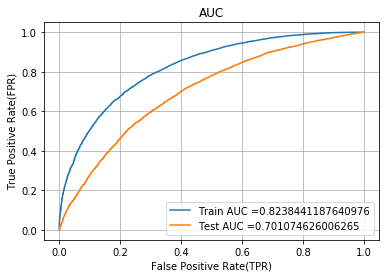

CPU times: user 34.5 s, sys: 47.6 ms, total: 34.6 s
Wall time: 34.2 s


In [124]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Creating the classifier with best parameters
classifier = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 82% and 70% respectively

# 4. Analyzing The Model

In [125]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [126]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8485756289700702
Precision on test set: 0.8485756289700702
Recall on test set: 1.0
F1-Score on test set: 0.9180859205017782
CPU times: user 8.54 s, sys: 0 ns, total: 8.54 s
Wall time: 8.35 s


In [127]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5454  1971]
 [10335 31279]]
Test confusion matrix
[[ 3500  1959]
 [10415 20177]]


### Function to create the confusion matrix

In [128]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

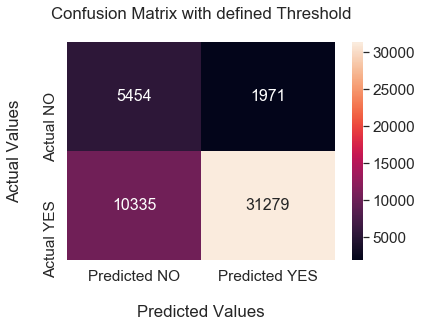

In [130]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

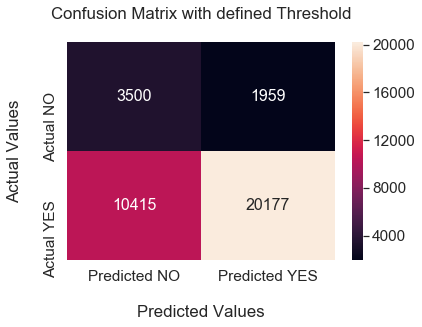

In [131]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 70%
2. The F1_score obtained is 0.9180859205017782

## 2. Applying Random Forests on TF-IDF,<font color='red'> SET 2</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [127]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_tfidf, X_train_titles_tfidf, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_tfidf, X_cv_titles_tfidf, 
               X_cv_clean_categories_0, X_cv_clean_categories_1, 
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1,
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_tfidf, X_test_titles_tfidf, 
               X_test_clean_categories_0, X_test_clean_categories_1, 
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1,
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()

## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14115) (49039,)
(24155, 14115) (24155,)
(36051, 14115) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [123]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = RandomForestClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [5, 10, 50, 100, 500], 'max_depth':[5, 10, 50, 100]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

CPU times: user 1h 10min 59s, sys: 5.43 s, total: 1h 11min 5s
Wall time: 1h 10min


In [124]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
clf.best_params_

{'max_depth': 50, 'n_estimators': 500}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 50, 'n_estimators': 500

In [117]:
# train_auc_tfidf = pd.DataFrame(train_auc)
# cv_auc_tfidf = pd.DataFrame(cv_auc)

# train_auc_tfidf.to_csv("train_auc_tfidf.csv", index = False)
# cv_auc_tfidf.to_csv("cv_auc_tfidf.csv", index = False)

In [118]:
train_auc = pd.read_csv("AUC/train_auc_tfidf.csv")
cv_auc = pd.read_csv("AUC/cv_auc_tfidf.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [119]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [120]:
len(train_auc)

20

In [121]:
len(cv_auc)

20

In [122]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100], index = Z_train_auc)

In [123]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDF',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Random-forest-TFIDF')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [121]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_tfidf = PrettyTable()

x_tfidf.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_tfidf.add_row([500, 5, 0.6931])
x_tfidf.add_row([500, 10, 0.6999])
x_tfidf.add_row([500, 50, 0.7152])
x_tfidf.add_row([500, 100, 0.7112])
print(x_tfidf)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      500       |      5      |  0.6931  |
|      500       |      10     |  0.6999  |
|      500       |      50     |  0.7152  |
|      500       |     100     |  0.7112  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 50), the AUC starts to decrease.
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted even though at 50 we get the max AUC
#### 3. At n_estimators = 500, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 500)

# 3. Now creating the model with best hyperparameters

In [139]:
best_max_depth = 8
best_n_estimators = 500

In [140]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

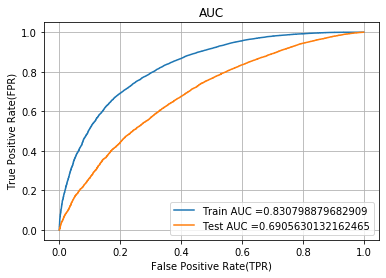

CPU times: user 45.1 s, sys: 47.9 ms, total: 45.2 s
Wall time: 44.8 s


In [141]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Creating the classifier with best parameters
classifier = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 83% and 69% respectively

# 4. Analyzing The Model

In [142]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [143]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8485756289700702
Precision on test set: 0.8485756289700702
Recall on test set: 1.0
F1-Score on test set: 0.9180859205017782
CPU times: user 8.18 s, sys: 20 ms, total: 8.2 s
Wall time: 8.01 s


In [144]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5546  1879]
 [10357 31257]]
Test confusion matrix
[[ 3495  1964]
 [11106 19486]]


### Function to create the confusion matrix

In [145]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

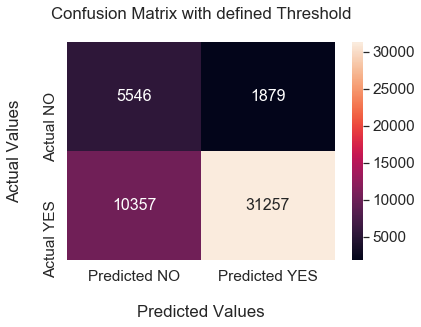

In [147]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

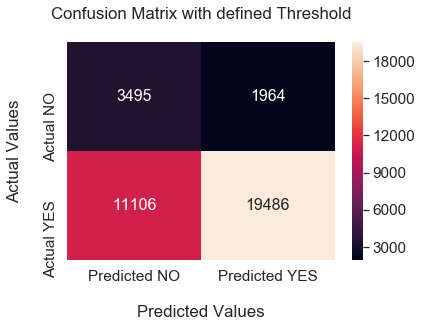

In [148]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 69%
2. The F1_score obtained is 0.9180859205017782

# 3. Applying Random Forestson AVG W2V,<font color='red'> SET 3</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [111]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = np.hstack((train_w2v_vectors_essays, train_w2v_vectors_titles, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity))
# CV data
X_cr = np.hstack((cv_w2v_vectors_essays, cv_w2v_vectors_titles, 
               X_cv_clean_categories_0, X_cv_clean_categories_1,
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1, 
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity))
# Test data
X_te = np.hstack((test_w2v_vectors_essays, test_w2v_vectors_titles, 
               X_test_clean_categories_0, X_test_clean_categories_1,
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1, 
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity))


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 613) (49039,)
(24155, 613) (24155,)
(36051, 613) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [121]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = RandomForestClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [5, 10, 50, 100, 500], 'max_depth':[5, 10, 50, 100]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/py

CPU times: user 9min 1s, sys: 540 ms, total: 9min 2s
Wall time: 2h 23min 58s


In [122]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [123]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 500}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'n_estimators': 500

In [112]:
# train_auc_avgw2v = pd.DataFrame(train_auc)
# cv_auc_avgw2v = pd.DataFrame(cv_auc)

# train_auc_avgw2v.to_csv("train_auc_avgw2v.csv", index = False)
# cv_auc_avgw2v.to_csv("cv_auc_avgw2v.csv", index = False)

In [113]:
train_auc = pd.read_csv("AUC/train_auc_avgw2v.csv")
cv_auc = pd.read_csv("AUC/cv_auc_avgw2v.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [114]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [115]:
len(train_auc)

20

In [116]:
len(cv_auc)

20

In [117]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100], index = Z_train_auc)

In [119]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - AVGW2V',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Random-forest-AVGW2V')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [120]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_avgw2v = PrettyTable()

x_avgw2v.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_avgw2v.add_row([500, 5, 0.6925])
x_avgw2v.add_row([500, 10, 0.6989])
x_avgw2v.add_row([500, 50, 0.6548])
x_avgw2v.add_row([500, 100, 0.6529])
print(x_avgw2v)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      500       |      5      |  0.6925  |
|      500       |      10     |  0.6989  |
|      500       |      50     |  0.6548  |
|      500       |     100     |  0.6529  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 500, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 500)

# 3. Now creating the model with best hyperparameters

In [129]:
best_max_depth = 7
best_n_estimators = 500

In [130]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

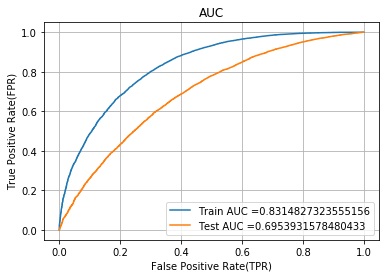

CPU times: user 5min 55s, sys: 30.8 ms, total: 5min 55s
Wall time: 5min 55s


In [131]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Creating the classifier with best parameters
classifier = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 83% and 69% respectively

# 4. Analyzing The Model

In [132]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [133]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8485756289700702
Precision on test set: 0.8485756289700702
Recall on test set: 1.0
F1-Score on test set: 0.9180859205017782
CPU times: user 2.66 s, sys: 32 ms, total: 2.69 s
Wall time: 2.69 s


In [134]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5394  2031]
 [ 9451 32163]]
Test confusion matrix
[[ 3441  2018]
 [10434 20158]]


### Function to create the confusion matrix

In [135]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

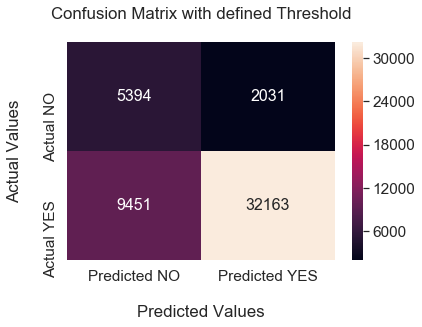

In [137]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

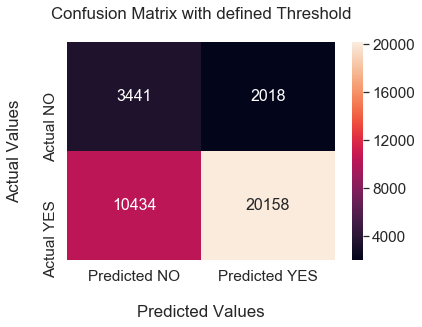

In [138]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 69%
2. The F1_score obtained is 0.9180859205017782

# 4. Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [111]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = np.hstack((train_tfidf_w2v_essays, train_tfidf_w2v_titles, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity))
# CV data
X_cr = np.hstack((cv_tfidf_w2v_essays, cv_tfidf_w2v_titles, 
               X_cv_clean_categories_0, X_cv_clean_categories_1,
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1, 
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity))
# Test data
X_te = np.hstack((test_tfidf_w2v_essays, test_tfidf_w2v_titles, 
               X_test_clean_categories_0, X_test_clean_categories_1,
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1, 
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity))


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 613) (49039,)
(24155, 613) (24155,)
(36051, 613) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [112]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = RandomForestClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [5, 10, 50, 100, 500], 'max_depth':[5, 10, 50, 100]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 8min 51s, sys: 636 ms, total: 8min 52s
Wall time: 2h 4min 32s


In [113]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 500}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 5, 'n_estimators': 500

In [115]:
# train_auc_tfidf_w2v = pd.DataFrame(train_auc)
# cv_auc_tfidf_w2v = pd.DataFrame(cv_auc)

# train_auc_tfidf_w2v.to_csv("train_auc_tfidf_w2v.csv", index = False)
# cv_auc_tfidf_w2v.to_csv("cv_auc_tfidf_w2v.csv", index = False)

In [116]:
train_auc = pd.read_csv("AUC/train_auc_tfidf_w2v.csv")
cv_auc = pd.read_csv("AUC/cv_auc_tfidf_w2v.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [117]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [118]:
len(train_auc)

20

In [119]:
len(cv_auc)

20

In [120]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500, 
                            5, 10, 50, 100, 500], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100], index = Z_train_auc)

In [121]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDFW2V',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Random-forest-TFIDFW2V')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [123]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_tfidfw2v = PrettyTable()

x_tfidfw2v.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_tfidfw2v.add_row([500, 5, 0.6975])
x_tfidfw2v.add_row([500, 10, 0.7005])
x_tfidfw2v.add_row([500, 50, 0.6505])
x_tfidfw2v.add_row([500, 100, 0.6495])
print(x_tfidfw2v)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      500       |      5      |  0.6975  |
|      500       |      10     |  0.7005  |
|      500       |      50     |  0.6505  |
|      500       |     100     |  0.6495  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 500, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 500)

# 3. Now creating the model with best hyperparameters

In [130]:
best_max_depth = 7
best_n_estimators = 500

In [131]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

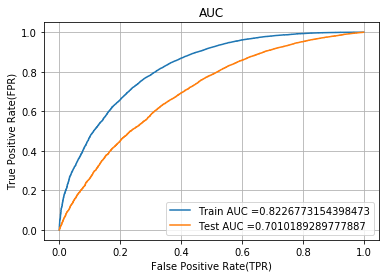

CPU times: user 5min 53s, sys: 74.7 ms, total: 5min 53s
Wall time: 5min 53s


In [132]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Creating the classifier with best parameters
classifier = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 82% and 70% respectively

# 4. Analyzing The Model

In [133]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [134]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8485756289700702
Precision on test set: 0.8485756289700702
Recall on test set: 1.0
F1-Score on test set: 0.9180859205017782
CPU times: user 2.71 s, sys: 32 ms, total: 2.74 s
Wall time: 2.74 s


In [135]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5354  2071]
 [ 9757 31857]]
Test confusion matrix
[[ 3593  1866]
 [11130 19462]]


### Function to create the confusion matrix

In [136]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

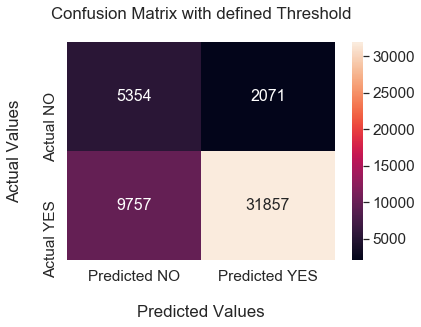

In [138]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

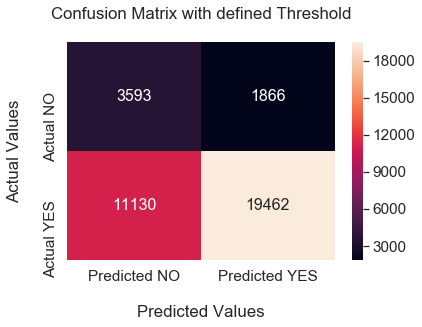

In [139]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 70%
2. The F1_score obtained is 0.9180859205017782

# [ Task - 2 ] Apply GBDT on different kinds of featurizations

## 1. Applying XGBOOST on BOW,<font color='red'> SET 1</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [109]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_bow, X_train_titles_bow, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_bow, X_cv_titles_bow, 
               X_cv_clean_categories_0, X_cv_clean_categories_1, 
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1,
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_bow, X_test_titles_bow, 
               X_test_clean_categories_0, X_test_clean_categories_1, 
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1,
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()

In [110]:
## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14097) (49039,)
(24155, 14097) (24155,)
(36051, 14097) (36051,)


## 1. Hyperparamter tuning to find best 'n_estimators' & 'max_depth' (Using GridSearchCV)

In [112]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRFClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = XGBRFClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth':[5, 10, 15, 20]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

CPU times: user 2min 50s, sys: 808 ms, total: 2min 51s
Wall time: 1h 1min 58s


In [113]:
clf.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=200, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [114]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 200}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'n_estimators': 200

In [115]:
# train_auc_BOW_xg = pd.DataFrame(train_auc)
# cv_auc_BOW_xg = pd.DataFrame(cv_auc)

# train_auc_BOW_xg.to_csv("train_auc_BOW_xg.csv", index = False)
# cv_auc_BOW_xg.to_csv("cv_auc_BOW_xg.csv", index = False)

In [116]:
train_auc = pd.read_csv("AUC/train_auc_BOW_xg.csv")
cv_auc = pd.read_csv("AUC/cv_auc_BOW_xg.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [117]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [118]:
len(train_auc)

20

In [119]:
len(cv_auc)

20

In [122]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         15,15,15,15,15,
                         20,20,20,20,20], index = Z_train_auc)

In [123]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - BOW (XGBOOST)',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='XGBOOST-BOW')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [124]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_bow = PrettyTable()

x_bow.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_bow.add_row([200, 5, 0.6778])
x_bow.add_row([200, 10, 0.6897])
x_bow.add_row([200, 15, 0.6884])
x_bow.add_row([200, 20, 0.6849])
print(x_bow)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      200       |      5      |  0.6778  |
|      200       |      10     |  0.6897  |
|      200       |      15     |  0.6884  |
|      200       |      20     |  0.6849  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 200, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 200)

# 3. Now creating the model with best hyperparameters

In [111]:
best_max_depth = 10
best_n_estimators = 200

In [112]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

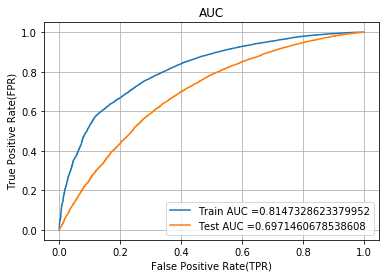

CPU times: user 2min 40s, sys: 211 ms, total: 2min 40s
Wall time: 2min 40s


In [113]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBRFClassifier

# Creating the classifier with best parameters
classifier = XGBRFClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 81% and 69.7% respectively

# 4. Analyzing The Model

In [114]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [115]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8485756289700702
Precision on test set: 0.8485949679602763
Recall on test set: 0.9999673117154811
F1-Score on test set: 0.9180834621329211
CPU times: user 2.59 s, sys: 48.1 ms, total: 2.64 s
Wall time: 2.63 s


In [116]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5407  2018]
 [10552 31062]]
Test confusion matrix
[[ 3602  1857]
 [11023 19569]]


### Function to create the confusion matrix

In [117]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

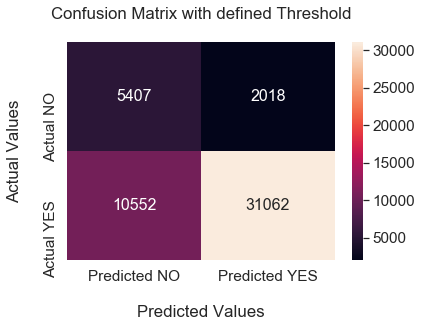

In [119]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

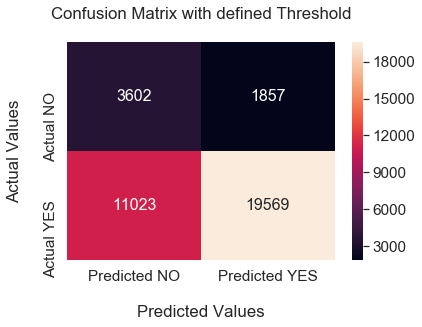

In [120]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 69.7%
2. The F1_score obtained is 0.9180834621329211

## 2. Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [109]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_tfidf, X_train_titles_tfidf, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_tfidf, X_cv_titles_tfidf, 
               X_cv_clean_categories_0, X_cv_clean_categories_1, 
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1,
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_tfidf, X_test_titles_tfidf, 
               X_test_clean_categories_0, X_test_clean_categories_1, 
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1,
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()
## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14236) (49039,)
(24155, 14236) (24155,)
(36051, 14236) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [110]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRFClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = XGBRFClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth':[5, 10, 15, 20]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

CPU times: user 8min 54s, sys: 547 ms, total: 8min 55s
Wall time: 2h 4min 27s


In [111]:
clf.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=15, min_child_weight=1, missing=None,
                n_estimators=200, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [112]:
clf.best_params_

{'max_depth': 15, 'n_estimators': 200}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 15, 'n_estimators': 200

In [111]:
# train_auc_tfidf_xg = pd.DataFrame(train_auc)
# cv_auc_tfidf_xg = pd.DataFrame(cv_auc)

# train_auc_tfidf_xg.to_csv("train_auc_tfidf_xg.csv", index = False)
# cv_auc_tfidf_xg.to_csv("cv_auc_tfidf_xg.csv", index = False)

In [112]:
train_auc = pd.read_csv("AUC/train_auc_tfidf_xg.csv")
cv_auc = pd.read_csv("AUC/cv_auc_tfidf_xg.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [113]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [114]:
len(train_auc)

20

In [115]:
len(cv_auc)

20

In [116]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         15,15,15,15,15,
                         20,20,20,20,20], index = Z_train_auc)

In [117]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDF (XGBOOST)',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='XGBOOST-TFIDF')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [123]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_tfidf = PrettyTable()

x_tfidf.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_tfidf.add_row([200, 5, 0.6793])
x_tfidf.add_row([200, 10, 0.6923])
x_tfidf.add_row([200, 15, 0.6931])
x_tfidf.add_row([200, 20, 0.6922])
print(x_tfidf)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      200       |      5      |  0.6793  |
|      200       |      10     |  0.6923  |
|      200       |      15     |  0.6931  |
|      200       |      20     |  0.6922  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 15), the AUC starts to decrease
#### 2. We can take vaues between 10 - 15 for max_depth. If we take 15, the model gets overfitted.
#### 3. At n_estimators = 200, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 200)

# 3. Now creating the model with best hyperparameters

In [118]:
best_max_depth = 10
best_n_estimators = 200

In [119]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

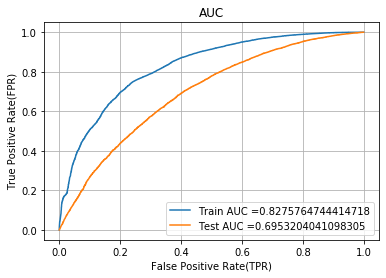

CPU times: user 5min 16s, sys: 299 ms, total: 5min 16s
Wall time: 5min 16s


In [120]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBRFClassifier

# Creating the classifier with best parameters
classifier = XGBRFClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 82% and 69.5% respectively

# 4. Analyzing The Model

In [124]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [125]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))

Accuracy on test set: 0.8493800449363402
Precision on test set: 0.8511107390042421
Recall on test set: 0.9968946129707112
F1-Score on test set: 0.9182524388775142
CPU times: user 2.74 s, sys: 36.1 ms, total: 2.77 s
Wall time: 2.77 s


In [126]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5641  1784]
 [10483 31131]]
Test confusion matrix
[[ 3334  2125]
 [ 9767 20825]]


### Function to create the confusion matrix

In [127]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

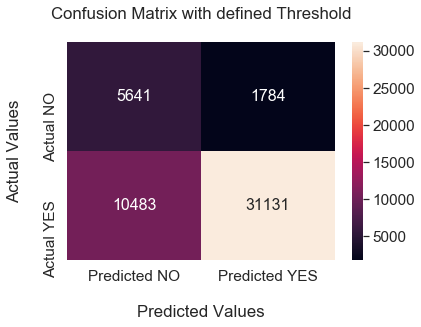

In [129]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

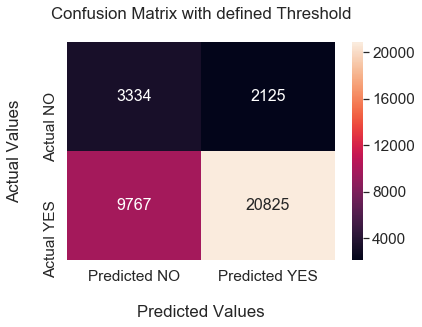

In [130]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 69.5%
2. The F1_score obtained is 0.9182524388775142

## 3. Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [111]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = np.hstack((train_w2v_vectors_essays, train_w2v_vectors_titles, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity))
# CV data
X_cr = np.hstack((cv_w2v_vectors_essays, cv_w2v_vectors_titles, 
               X_cv_clean_categories_0, X_cv_clean_categories_1,
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1, 
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity))
# Test data
X_te = np.hstack((test_w2v_vectors_essays, test_w2v_vectors_titles, 
               X_test_clean_categories_0, X_test_clean_categories_1,
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1, 
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity))


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 613) (49039,)
(24155, 613) (24155,)
(36051, 613) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [112]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRFClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = XGBRFClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth':[5, 10, 15, 20]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 14min 41s, sys: 737 ms, total: 14min 41s
Wall time: 5h 42min 18s


In [113]:
clf.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=200, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [114]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 200}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'n_estimators': 200

In [115]:
# train_auc_avgw2v_xg = pd.DataFrame(train_auc)
# cv_auc_avgw2v_xg = pd.DataFrame(cv_auc)

# train_auc_avgw2v_xg.to_csv("train_auc_avgw2v_xg.csv", index = False)
# cv_auc_avgw2v_xg.to_csv("cv_auc_avgw2v_xg.csv", index = False)

In [116]:
train_auc = pd.read_csv("AUC/train_auc_avgw2v_xg.csv")
cv_auc = pd.read_csv("AUC/cv_auc_avgw2v_xg.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [117]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [118]:
len(train_auc)

20

In [119]:
len(cv_auc)

20

In [120]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         15,15,15,15,15,
                         20,20,20,20,20], index = Z_train_auc)

In [121]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - AVGW2V (XGBOOST)',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='XGBOOST-AVGW2V')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [122]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_avgw2v = PrettyTable()

x_avgw2v.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_avgw2v.add_row([200, 5, 0.6902])
x_avgw2v.add_row([200, 10, 0.7056])
x_avgw2v.add_row([200, 15, 0.7051])
x_avgw2v.add_row([200, 20, 0.7021])
print(x_avgw2v)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      200       |      5      |  0.6902  |
|      200       |      10     |  0.7056  |
|      200       |      15     |  0.7051  |
|      200       |      20     |  0.7021  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 200, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 200)

# 3. Now creating the model with best hyperparameters

In [124]:
best_max_depth = 8
best_n_estimators = 200

In [125]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

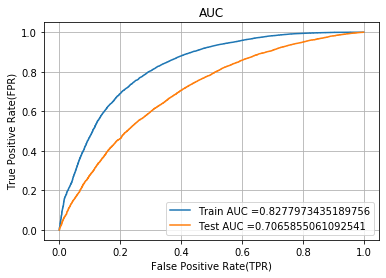

CPU times: user 11min 31s, sys: 405 ms, total: 11min 31s
Wall time: 11min 31s


In [126]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBRFClassifier

# Creating the classifier with best parameters
classifier = XGBRFClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 82% and 70% respectively

# 4. Analyzing The Model

In [127]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [128]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8487420598596432
Precision on test set: 0.8487942947526154
Recall on test set: 0.9998692468619247
F1-Score on test set: 0.9181587596992301
CPU times: user 1.02 s, sys: 80.1 ms, total: 1.1 s
Wall time: 1.1 s


In [129]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5463  1962]
 [ 9570 32044]]
Test confusion matrix
[[ 3489  1970]
 [10206 20386]]


### Function to create the confusion matrix

In [130]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

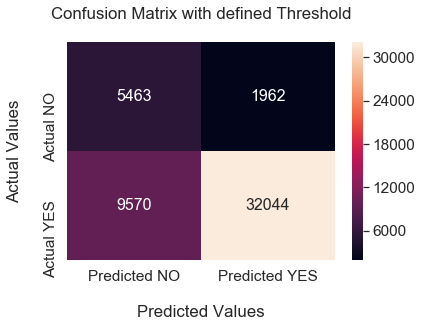

In [132]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

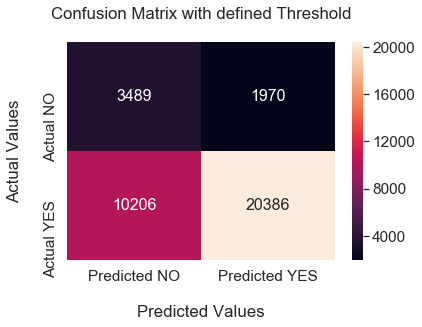

In [133]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 70%
2. The F1_score obtained is 0.9181587596992301

## 4. Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [111]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = np.hstack((train_tfidf_w2v_essays, train_tfidf_w2v_titles, 
               X_train_clean_categories_0, X_train_clean_categories_1,
               X_train_clean_subcategories_0, X_train_clean_subcategories_1,
               X_train_proj_grade_0, X_train_proj_grade_1, 
               X_train_school_state_0, X_train_school_state_1,
               X_train_teacher_prefix_0, X_train_teacher_prefix_1,
               X_train_previous_projects, X_train_price, X_train_quantity))
# CV data
X_cr = np.hstack((cv_tfidf_w2v_essays, cv_tfidf_w2v_titles, 
               X_cv_clean_categories_0, X_cv_clean_categories_1,
               X_cv_clean_subcategories_0, X_cv_clean_subcategories_1,
               X_cv_proj_grade_0, X_cv_proj_grade_1, 
               X_cv_school_state_0, X_cv_school_state_1,
               X_cv_teacher_prefix_0, X_cv_teacher_prefix_1,
               X_cv_previous_projects, X_cv_price, X_cv_quantity))
# Test data
X_te = np.hstack((test_tfidf_w2v_essays, test_tfidf_w2v_titles, 
               X_test_clean_categories_0, X_test_clean_categories_1,
               X_test_clean_subcategories_0, X_test_clean_subcategories_1,
               X_test_proj_grade_0, X_test_proj_grade_1, 
               X_test_school_state_0, X_test_school_state_1,
               X_test_teacher_prefix_0, X_test_teacher_prefix_1,
               X_test_previous_projects, X_test_price, X_test_quantity))


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 613) (49039,)
(24155, 613) (24155,)
(36051, 613) (36051,)


## 1. Hyperparamter tuning to find best 'depth' & 'n_estimators' (Using GridSearchCV)

In [112]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRFClassifier
from sklearn.metrics import roc_curve, auc

# creating Random Forests classifier
classifier = XGBRFClassifier()

# Depth and min_sample_split values
parameters = {'n_estimators': [10, 25, 50, 100, 200], 'max_depth':[5, 10, 15, 20]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 

CPU times: user 14min 22s, sys: 754 ms, total: 14min 23s
Wall time: 4h 40min 52s


In [113]:
clf.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=200, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [114]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 200}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'n_estimators': 200

In [112]:
# train_auc_tfidfw2v_xg = pd.DataFrame(train_auc)
# cv_auc_tfidfw2v_xg = pd.DataFrame(cv_auc)

# train_auc_tfidfw2v_xg.to_csv("train_auc_tfidfw2v_xg.csv", index = False)
# cv_auc_tfidfw2v_xg.to_csv("cv_auc_tfidfw2v_xg.csv", index = False)

In [113]:
train_auc = pd.read_csv("AUC/train_auc_tfidfw2v_xg.csv")
cv_auc = pd.read_csv("AUC/cv_auc_tfidfw2v_xg.csv")

train_auc = list(train_auc["0"])
cv_auc = list(cv_auc["0"])

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - n_estimators"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [114]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = n_estimators

In [115]:
len(train_auc)

20

In [116]:
len(cv_auc)

20

In [117]:
## auc_scores
Z_train_auc = train_auc

## auc_scores
Z_cv_auc = cv_auc

## min_sample_splits
X_n_estimators = pd.Series([10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200, 
                            10, 25, 50, 100, 200], index = Z_train_auc)
## max_depth
Y_max_depth = pd.Series([5,5,5,5,5,
                         10,10,10,10,10,
                         15,15,15,15,15,
                         20,20,20,20,20], index = Z_train_auc)

In [118]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_train_auc,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_n_estimators, y = Y_max_depth, z = Z_cv_auc,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDF_W2V (XGBOOST)',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='n_estimators',
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='max_depth',
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    title='AUC',
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='XGBOOST-TFIDF_W2V')

## NOTE:
### From the above plot of AUC, if we observe the plot and the points carefully we can draw the following conclusion:

In [119]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_tfidfw2v = PrettyTable()

x_tfidfw2v.field_names = ["X_n_estimators", "Y_max_depth", "Z_cv_auc"]
x_tfidfw2v.add_row([200, 5, 0.6904])
x_tfidfw2v.add_row([200, 10, 0.7040])
x_tfidfw2v.add_row([200, 15, 0.7018])
x_tfidfw2v.add_row([200, 20, 0.6971])
print(x_tfidfw2v)

+----------------+-------------+----------+
| X_n_estimators | Y_max_depth | Z_cv_auc |
+----------------+-------------+----------+
|      200       |      5      |  0.6904  |
|      200       |      10     |  0.704   |
|      200       |      15     |  0.7018  |
|      200       |      20     |  0.6971  |
+----------------+-------------+----------+


#### 1. As the max_depth is increasing (after max_depth = 10), the AUC starts to decrease
#### 2. We can take vaues between 5 - 10 for max_depth. If we take 10, the model gets overfitted.
#### 3. At n_estimators = 200, the model is giving the highest AUC. So even if we increase the n_estimators up to 1000, the model is giving the same results. (I tried increasing the n_estimators to 1000 and I got no change. So I kept the n_estimators to 200)

# 3. Now creating the model with best hyperparameters

In [120]:
best_max_depth = 8
best_n_estimators = 200

In [121]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

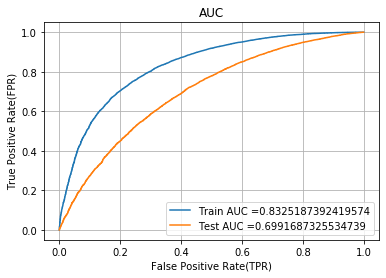

CPU times: user 11min 22s, sys: 285 ms, total: 11min 22s
Wall time: 11min 22s


In [122]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBRFClassifier

# Creating the classifier with best parameters
classifier = XGBRFClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 83% and 70% respectively

# 4. Analyzing The Model

In [123]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [124]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8486865828964523
Precision on test set: 0.8486697922157184
Recall on test set: 1.0
F1-Score on test set: 0.9181410285268385
CPU times: user 1.15 s, sys: 104 ms, total: 1.25 s
Wall time: 1.25 s


In [125]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5640  1785]
 [10385 31229]]
Test confusion matrix
[[ 3445  2014]
 [10341 20251]]


### Function to create the confusion matrix

In [126]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

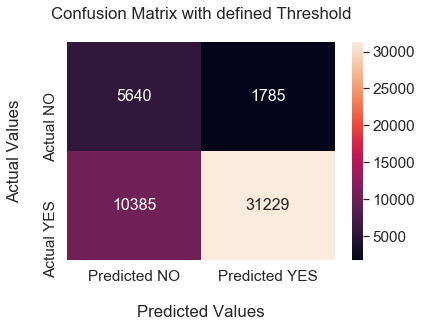

In [128]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

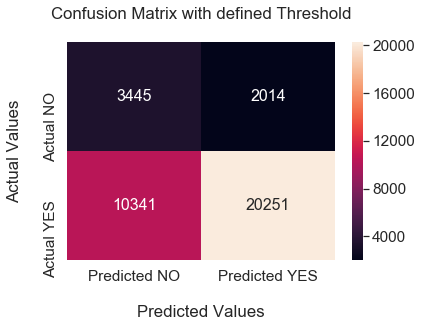

In [129]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 70%
2. The F1_score obtained is 0.9181410285268385

# CONCLUSION

In [126]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
y = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameters(max_depth, n_estimators)", "Train AUC", "Test AUC"]
x.add_row(["BOW", "Random Forest","(10,500)", 0.85, 0.70])
x.add_row(["TFIDF", "Random Forest", "(10,500)", 0.87, 0.70])
x.add_row(["AVG W2V", "Random Forest", "(10,500)", 0.94, 0.70])
x.add_row(["TFIDF W2V", "Random Forest", "(10,500)", 0.94, 0.70])
print(x,'\n')

print("="*95)

y.field_names = ["Vectorizer", "Model", "Hyperparameters(max_depth, n_estimators)", "Train AUC", "Test AUC"]
y.add_row(["BOW", "XGBOOST-GBDT","(10,200)", 0.80, 0.70])
y.add_row(["TFIDF", "XGBOOST-GBDT", "(15,200)", 0.91, 0.70])
y.add_row(["AVG W2V", "XGBOOST-GBDT", "(10,200)", 0.89, 0.70])
y.add_row(["TFIDF W2V", "XGBOOST-GBDT", "(10,200)", 0.90, 0.70])
print(y)


+------------+---------------+------------------------------------------+-----------+----------+
| Vectorizer |     Model     | Hyperparameters(max_depth, n_estimators) | Train AUC | Test AUC |
+------------+---------------+------------------------------------------+-----------+----------+
|    BOW     | Random Forest |                 (10,500)                 |    0.85   |   0.7    |
|   TFIDF    | Random Forest |                 (10,500)                 |    0.87   |   0.7    |
|  AVG W2V   | Random Forest |                 (10,500)                 |    0.94   |   0.7    |
| TFIDF W2V  | Random Forest |                 (10,500)                 |    0.94   |   0.7    |
+------------+---------------+------------------------------------------+-----------+----------+ 

+------------+--------------+------------------------------------------+-----------+----------+
| Vectorizer |    Model     | Hyperparameters(max_depth, n_estimators) | Train AUC | Test AUC |
+------------+--------------+-

1. Since there were 3 dimensions to plot, so I had to use plotly and had to plot the train and cv results along with the max_depth and n_estimators.
2. The above table shows us that the model is performing well on training data for all vectorizers but with the test data it somewhat struggling.
3. XGBOOST performs well on the same data than random forest algorithm.
4. I used less number of n_estimators because it would take a lot of time to cross validate the model using larger value of n_estimators